## 추가과제
### 여러분들 수집한 책 목록을 먼저 TIOBE INDEX 20위까지 확장해서 검색해주세요.
- 검색할때 책 가격과 페이지수도 함께 수집해 주세요.
- 그리고 아래 질문에 답해주세요.
- 언어별 책의 가격은 어떤 특성이 있나요?
- 언어별 페이지수도 어떤 특성이 있나요?
- 페이지 수와 가격 사이에는 어떤 특성이 있나요?

---

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import set_matplotlib_hangul
import urllib.request
import datetime
import json
import copy
import ssl
import re

from urllib.request import Request, urlopen
from urllib.request import HTTPError
from bs4 import BeautifulSoup
from tqdm import tqdm
%matplotlib inline

Hangul OK in your Windows!!!


In [3]:
client_id = "MadIM69g5849lC6DDC_5" 
client_secret = "ipBAFSsbIT" 

encText = urllib.parse.quote("파이썬")
url = "https://openapi.naver.com/v1/search/book?query=" + encText 

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()

if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)

## 필요한 함수 생성
- gen_search_url 
    - 찾고자하는 url 생성
- get_result_onpage
    - 획득한 웹페이지의 내용 추출
- getPage
    - 책의 페이지수 추출
- SearchBooks
    - 책 정보 획득


In [4]:
def gen_search_url(api_node, search_text, start_num, disp_num): #찾을 url 생성(generate)
    base = "https://openapi.naver.com/v1/search/"
    node = "/"+ api_node + ".json"
    param_query = "?query="+urllib.parse.quote(search_text)
    param_start = "&start="+str(start_num)
    param_disp = "&display=" + str(disp_num)

    return base+node+param_query+param_start+param_disp

In [5]:
def get_result_onpage(url):
    request = urllib.request.Request(url) #요청할 url
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)

    response = urllib.request.urlopen(request)
    #print("[%s] Url Request Success"% datetime.datetime.now()) #현재 시간 찍기
    return json.loads(response.read().decode("utf-8"))

In [6]:
def getPage(links):
    pages = []
    for url in links:
        context = ssl._create_unverified_context() #ssl 해결방법
        req = Request(url, headers={"User-agent": "Chrome"}) # 403 Error 해결방법
        try:
            html = urlopen(req,context=context)
        except HTTPError as e:
            #print(e)
            #print("에러난 url {}".format(url))
            pages.append(0)
            continue
        else :
            soup = BeautifulSoup(html,"html.parser")
            try :
                page = soup.select_one("#container > div.spot > div.book_info > div.book_info_inner > div:nth-child(3)").get_text()[5:8]
                pages.append(page)
            except:
                pages.append(0)
    return pages

In [7]:
#import pandas as pd
def get_fields(json_data,language):
    title = [each["title"].replace("<b>"," ").replace("</b>"," ") for each in json_data["items"]]
    link = [each["link"] for each in json_data["items"]]
    # image = [each["image"] for each in json_data["items"]]
    author = [each["author"] for each in json_data["items"]]
    price = [each["price"] for each in json_data["items"]]
    discount = [each["discount"] for each in json_data["items"]]
    publisher = [each["publisher"].replace("<b>"," ").replace("</b>"," ") for each in json_data["items"]]
    pubdate = [each["pubdate"] for each in json_data["items"]]
    isbn = [each["isbn"] for each in json_data["items"]]
    # description = [each["description"].replace("<b>"," ").replace("</b>"," ") for each in json_data["items"]]
    
    pages = getPage(link) # page얻어서

    result_pd = pd.DataFrame({
        "language":language[0],
        "title":title,
        "link":link,
        # "image":image,
        "author":author,
        "price":price,
        "discount":discount,
        "publisher":publisher,
        "pubdate":pubdate,
        "isbn":isbn,
        "pages":pages
        # "description":description
    }, 
    columns=["language","title","author","pages","price","discount","publisher","pubdate","isbn"])
    return result_pd

In [8]:
def SearchBooks(languages):
    result_book = []
    for language in tqdm(languages):
        for lan in language:
            #print(language)
            for n in range(1,100,20):
                url = gen_search_url("book", lan, n,20) #n페이지부터 20개 ( 1~ 20, 21~40)
                json_result = get_result_onpage(url) #받은 내용을 json으로 넣기
                pd_result = get_fields(json_result,language) #데이터 프레임으로 바꾸기

                result_book.append(pd_result)
    result_book = pd.concat(result_book)
    result_book.reset_index(drop=True,inplace=True)
    return result_book

In [9]:
languages = [ ["Python","파이썬","파이선"] ,["C언어"],["JAVA","Java"],["C++"],["C#"],\
["Visual Basic"],["JavaScript","자바스크립트"],["SQL"],["PHP"],["Assembly language","어셈블리"],\
    ["Classic Visual Basic"],["Go"],["MATLAB","매틀랩"],["R언어","R 데이터"],["Groovy"],\
        ["Ruby","루비"],["Swift","스위프트"],["Fotran","포트란"],["perl","펄"],["Pascal","파스칼"]]

## 데이터를 수집하는 함수 실행

In [10]:
result_book = SearchBooks(languages)
result_book.tail()

100%|██████████| 20/20 [13:59<00:00, 41.97s/it]


,language,title,author,pages,price,discount,publisher,pubdate,isbn
2962,Pascal,아우슈비츠,<b>파스칼</b> 크로시,sch,8000,,문학세계사,20030506,8970752803 9788970752808
2963,Pascal,블랙홀 이란 무엇인가 (천체 물리학으로 파헤친 블랙홀의 비밀),<b>파스칼</b> 보르데,'es,6500,,민음in,20060731,8982731512 9788982731518
2964,Pascal,30분 심플 쿠킹 (로레인 파스칼 의),로레인 <b>파스칼</b>,me,16800,15120,싸이프레스,20140217,8997125400 9788997125401
2965,Pascal,로레인 파스칼 의 30분 심플 베이킹,로레인 <b>파스칼</b>,kin,16800,15120,싸이프레스,20130211,8997125249 9788997125241
2966,Pascal,열려라 우리몸 (우리 아이 첫 인체 체험책),<b>파스칼</b> 에들랭,28|,25000,,주니어중앙,20100820,8927800095 9788927800095


In [11]:
result_book = result_book[result_book["pages"]!=0] #에러난 내용 삭제

In [12]:
copy_data = copy.deepcopy(result_book)

In [13]:
# 책 제목에서 관련없는 내용을 삭제하는 코드
result_book.reset_index(inplace=True) 
titles = [ "Python","python","PYTHON","파이썬","파이선","C","자바","JAVA","Java","java","Visual Basic","JavaScript","javascript","자바스크립트","SQL","sql","PHP","php",\
    "Assembly language","assembly language","어셈블리","Classic Visual Basic","classic visual basic","Go","go","matlab","MATLAB","매틀랩","R언어","R 언어","R 데이터",\
        "Groovy","groovy","Ruby","ruby","루비","Swift","swift","스위프트","Fotran","fotran","포트란","perl","Perl","펄","Pascal","pascal","파스칼"]
limit = len(titles)
import re
pattern = re.compile(r'[ㄱ-ㅣ가-힣]')
notPagePattern = re.compile(r'[a-z|A-Z|\|]')
for i in range(len(result_book)):
    cnt = 0
    for title in titles:
        if title in result_book.loc[i,"title"]:
            continue
            #print(result_book.loc[i,"title"])
        else : 
            cnt+=1
    if cnt == limit:
        result_book =  result_book.drop(i,0)
    ##예외처리
    elif "perl" in result_book.loc[i,"author"]: #작가명에 perl포함되면 삭제
        result_book =  result_book.drop(i,0)
    elif  notPagePattern.search(result_book.loc[i,"pages"]) : #페이지에 없어야할 문자가 있으면
        result_book =  result_book.drop(i,0)
    elif result_book.loc[i,"price"]=="":#값이 비어있으면
        result_book =  result_book.drop(i,0)
    #해외출판사 삭제
    elif pattern.search(result_book.loc[i,"publisher"]): #출판사명에 한글이 들어있으면
        pass#print(result_book.loc[i,"publisher"]
    else :
        result_book =  result_book.drop(i,0)
        #print(result_book.loc[i,"title"])
    

C:\Users\82103\AppData\Local\Temp/ipykernel_44976/1024595066.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  result_book =  result_book.drop(i,0)
C:\Users\82103\AppData\Local\Temp/ipykernel_44976/1024595066.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  result_book =  result_book.drop(i,0)
C:\Users\82103\AppData\Local\Temp/ipykernel_44976/1024595066.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  result_book =  result_book.drop(i,0)
C:\Users\82103\AppData\Local\Temp/ipykernel_44976/1024595066.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  result_book =  result_book.drop(i,0)


In [14]:
len(result_book["isbn"].unique())

810

In [15]:
result_book.drop_duplicates(["isbn"],inplace=True) #isbn 컬럼을 기준으로 중복된 값있으면 1개 제외하고 삭제

In [16]:
# pubCnt = result_book.groupby("language").count() #
# pubCnt.sort_values(by="title",ascending=False,inplace=True)
# pubCnt = pubCnt["title"]

## 획득한 결과를 재가공하여 책 가격과 페이지를 표현하였다.

In [17]:
tmpdata = copy.deepcopy(result_book)
pagePriceDate = tmpdata[["pages","price"]].apply(pd.to_numeric, errors = 'coerce') 
pagePriceDate["title"] = result_book["title"]
pagePriceDate["language"] = result_book["language"]
pagePriceDate["Price/Page"] = pagePriceDate["price"]/pagePriceDate["pages"]
pagePriceDate

,pages,price,title,language,Price/Page
0,640.0,32000,Effective Python 2nd 이펙티브 파이썬 : 파이썬 코딩의 기술 (...,Python,50.000000
1,310.0,25000,파이썬 딥러닝 파이토치( Python Deep Learning PyTorch),Python,80.645161
3,368.0,26000,Python 으로 시작하는 빅데이터분석 및 인공지능 (개정판),Python,70.652174
5,308.0,23000,AI 수학 with Python (처음 만나는) (한 권으로 배우는 인공지능 수학...,Python,74.675325
6,544.0,30000,"파이썬으로 배우는 게임 개발: 실전편 (장애물 피하기, 닷잇 액션, 맵 에티터, 탄...",Python,55.147059
...,...,...,...,...,...
2718,253.0,13600,"PASCAL 'S PENSEES, VOL. 02 - 파스칼 팡세, 2부 (영문원서)",Pascal,53.754941
2725,323.0,27000,"파스칼의명상록 팡세.The Book of Pascal 's Pensees, by ...",Pascal,83.591331
2773,160.0,22000,지도로 보는 세계정세 (국제관계 전문가 파스칼 보니파스가 바라본 글로벌 이슈와 ...,Pascal,137.500000
2821,476.0,10000,파스칼 (대학고전총서 16),Pascal,21.008403


In [18]:
priceByLang = pagePriceDate.pivot_table(
    index = "language",
    values = ["price","pages","Price/Page"],
    aggfunc = np.mean
)
#priceByLang1["price"]

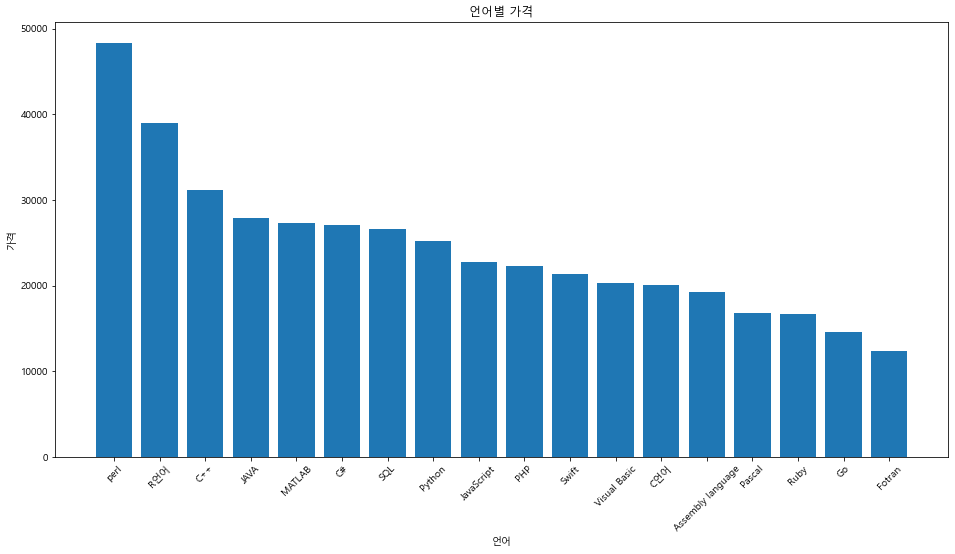

In [19]:
priceByLang.sort_values(by="price",ascending=False,inplace=True)
priceByLang
label = priceByLang.index
label
plt.figure(figsize=(16,8))
plt.bar(
    label,
    priceByLang["price"]
)
plt.title("언어별 가격")
plt.xlabel("언어")
plt.ylabel("가격")
plt.xticks(np.arange(0,len(priceByLang),step=1),rotation=45)
plt.show()

## 언어별 책의 가격
- 대부분 20,000원 대 전후로 가격이 형성되어있음을 확인할 수 있다.
- 다만, Perl는 4만원이상, R과 C++은 3만원대에 형성되어있음을 확인할 수 있다
- 인기가 높은 Python,Java 등의 가격은 대체로 평이한 반면
- HIOBE 순위가 낮은 언어들의 관련 책 가격이 높게 형성되어있다.

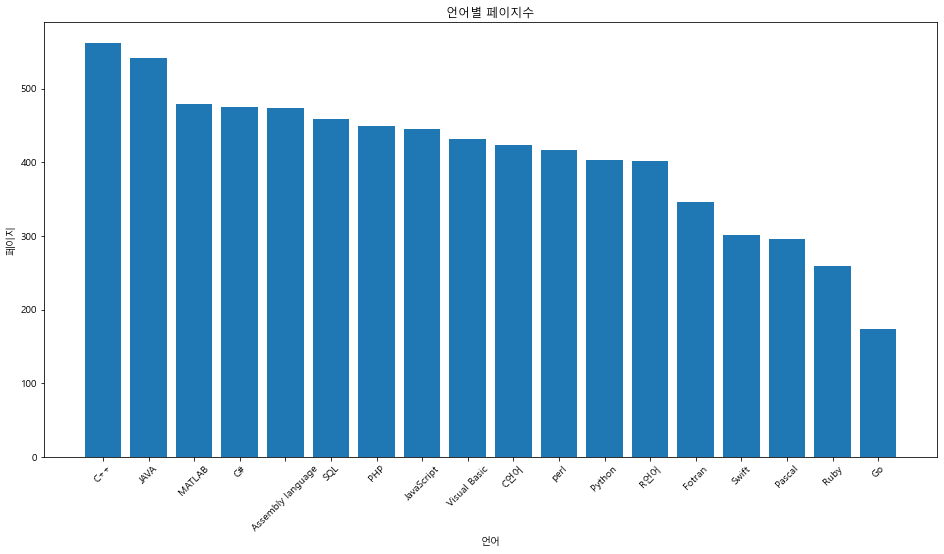

In [20]:
priceByLang.sort_values(by="pages",ascending=False,inplace=True)
pagesByLang = priceByLang
label = pagesByLang.index
label
plt.figure(figsize=(16,8))
plt.bar(
    label,
    pagesByLang["pages"]
)
plt.title("언어별 페이지수")
plt.xlabel("언어")
plt.ylabel("페이지")
plt.xticks(np.arange(0,len(pagesByLang),step=1),rotation=45)
plt.show()

## 언어별 페이지수
- 페이지는 C++, JAVA가 500페이지 이상으로 가장 많은 페이지수를 보이고 있다.
- Swift, Pascal, Ruby, Go는 300페이지 미만으로 타 언어에 비해 적은 페이지수를 보이고 있다.
- 한편, 대체적으로 300 - 400 페이지의 양을 보이고 있다.

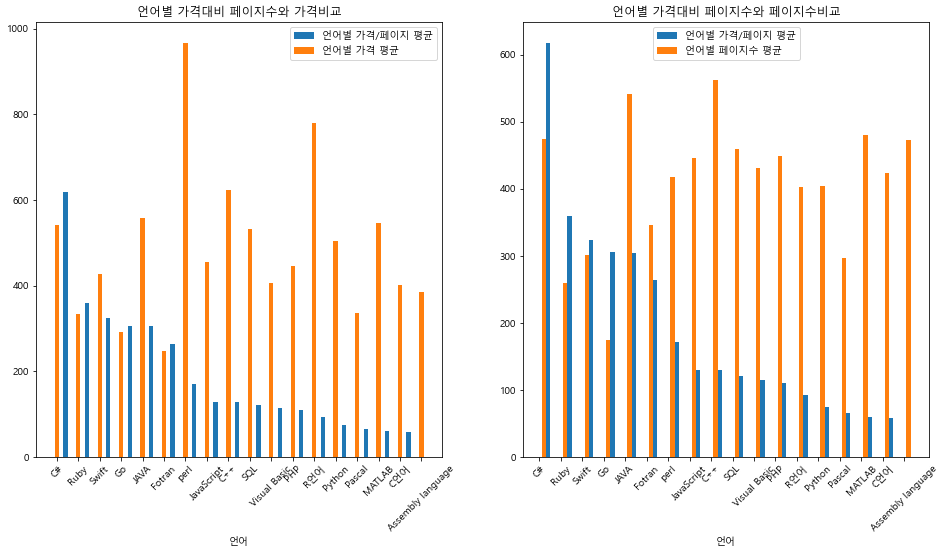

In [21]:
priceByLang.sort_values(by="Price/Page",ascending=False,inplace=True)
priceByLang
x = np.arange(len(priceByLang.index))
x
label = priceByLang.index
label

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.bar(x+0.4,priceByLang["Price/Page"],width=0.2,label="언어별 가격/페이지 평균")
plt.bar(x,priceByLang["price"]/50,width=0.2,label="언어별 가격 평균")
plt.title("언어별 가격대비 페이지수와 가격비교")
plt.xlabel("언어")
plt.xticks(x,label,rotation=45)
plt.legend()

plt.subplot(1,2,2)
plt.bar(x+0.4,priceByLang["Price/Page"],width=0.2,label="언어별 가격/페이지 평균")
plt.bar(x+0.2,priceByLang["pages"],width=0.2,label="언어별 페이지수 평균")
plt.title("언어별 가격대비 페이지수와 페이지수비교")
plt.xlabel("언어")

plt.xticks(x,label,rotation=45)
plt.legend()

plt.show()

## 페이지 수와 가격 사이 특성
- 가격 / 페이지수 를 한 결과를 기준으로 내림차순으로 정렬하여 나열해 보았다.
- 가격은 10,000 단위이므로 페이지와 시각적으로 맞추기 위해 50으로 나누어 주었다.
- 가격 / 페이지수와 각각 데이터는 언어별로는 큰 관련이 없는 것 처럼 보인다.
- 다만, 언어를 통합하여 가격과 페이지를 기준으로 2차원 좌표상에 그래프를 그려보니
    - 우상향하는 그래프가 나오는 것으로 보아
    - 페이지수와 가격은 정비례 관계에 있는 것으로 판단된다.

In [22]:
pagePriceDate.reset_index(drop=True,inplace=True)
lmdata = pagePriceDate[["pages","price"]]
lmdata = lmdata[(lmdata["pages"]>100) & (lmdata["price"]<300000)]
lmdata.head()

,pages,price
0,640.0,32000
1,310.0,25000
2,368.0,26000
3,308.0,23000
4,544.0,30000


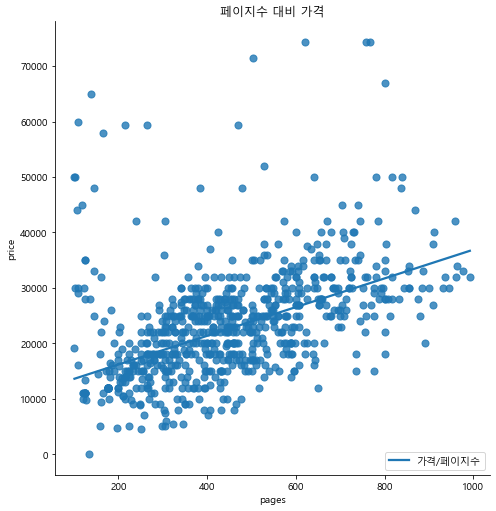

In [23]:
#페이지수 가격 xy그래프
data = lmdata
import seaborn as sns

sns.lmplot(
    x="pages",
    y="price",
    data=data,#["pages","price"], #dataset이 I인 행만 가져와서 데이터로 사용
    ci = None, # 신뢰구간을 선택 
    height = 7, # == size
    robust = True,
    scatter_kws= {"s": 50}, # marker의 사이즈(s)를 50으로... 
    order = 1 #2차원
    );
plt.title("페이지수 대비 가격")
plt.legend(labels = ['가격/페이지수'],loc = 'lower right');
#priceByLang1

---
